# Chapter py_07 
 Statistics for Data Science and Analytics<br>
by Peter C. Bruce, Peter Gedeck, Janet F. Dobbins

Publisher: Wiley; 1st edition (2024) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2024 Peter C. Bruce, Peter Gedeck, Janet F. Dobbins

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors. 
"Warnings" are for information only and can usually be ignored. 
"Errors" will stop execution and need to be fixed in order to get results. 

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/sdsa-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/sdsa-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

# Implement simple random sample (SRS)

Mean: 36.001


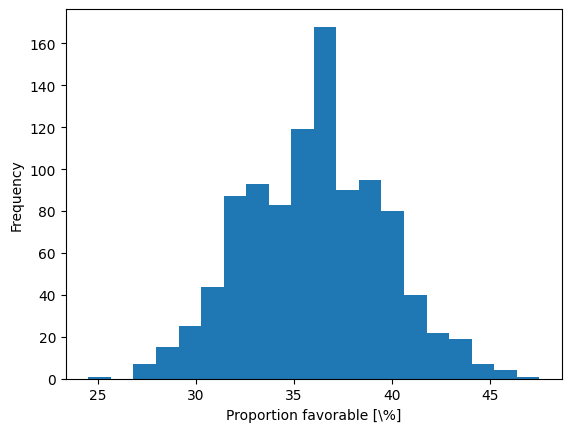

In [2]:
import random
import matplotlib.pyplot as plt

random.seed(123)
box = [0] * 128 + [1] * 72
# Repeated sampling
nsamples = 1000
proportion = []
for _ in range(nsamples):
    nr_ones = 0
    for _ in range(len(box)):
        random.shuffle(box)
        sample = random.choice(box)
        if sample == 1:
            nr_ones += 1
    proportion.append(nr_ones / len(box) * 100)
# Visualize the results
fig, ax = plt.subplots()
ax.hist(proportion, bins=20)
ax.set_xlabel("Proportion favorable [\%]")
ax.set_ylabel("Frequency")
print(f"Mean: {sum(proportion)/len(proportion)}")
plt.show()

 Improved version of the sampling experiment

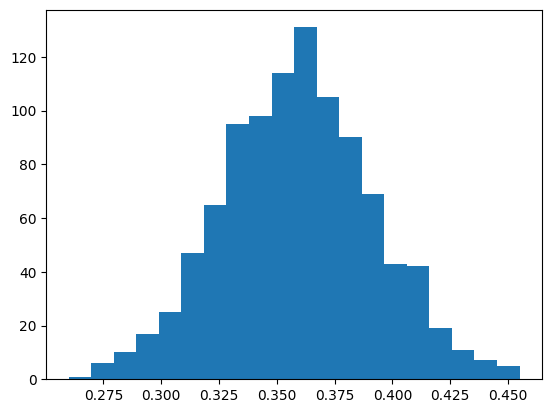

Mean: 0.35907500000000026


In [3]:
proportion = []
for _ in range(nsamples):
    samples = random.choices(box, k=len(box))
    nr_ones = sum(samples)
    proportion.append(nr_ones / len(box))
# Visualize the results
fig, ax = plt.subplots()
ax.hist(proportion, bins=20)
plt.show()
print(f"Mean: {sum(proportion)/len(proportion)}")

 Using weights instead of a box

In [4]:
import numpy as np
population_size = 200
proportion = []
for _ in range(nsamples):
    samples = random.choices([0, 1], weights=[128, 72], k=population_size)
    proportion.append(sum(samples) / population_size)
print(f"Mean: {np.mean(proportion)}")

Mean: 0.36045


## Determining confidence intervals

In [5]:
percentiles = [0.025, 0.975]
sorted_proportion = sorted(proportion)
lower = sorted_proportion[round(percentiles[0] * nsamples)]
upper = sorted_proportion[round(percentiles[1] * nsamples)]
print(f"Confidence interval: [{lower:.3f}, {upper:.3f}]")

Confidence interval: [0.295, 0.430]


 Using `np.percentile` to determine the confidence interval

In [6]:
import numpy as np
lower, upper = np.percentile(proportion, [2.5, 97.5])
print(f"Confidence interval: [{lower:.3f}, {upper:.3f}]")

Confidence interval: [0.295, 0.430]


 Using the normal approximation to determine the confidence interval

In [7]:
from scipy import stats
p = np.mean(proportion)
n = population_size
z = stats.norm().ppf(0.975)
lower = p - z * np.sqrt(p * (1 - p) / n)
upper = p + z * np.sqrt(p * (1 - p) / n)
print(f"Confidence interval: [{lower:.3f}, {upper:.3f}]")

Confidence interval: [0.294, 0.427]


In [8]:
from statsmodels.stats.proportion import proportion_confint
ci_interval = proportion_confint(72, 200, alpha=0.05, method="normal")
print(f"Confidence interval (normal): [{ci_interval[0]:.3f}, {ci_interval[1]:.3f}]")
ci_interval = proportion_confint(72, 200, alpha=0.05, method="beta")
print(f"Confidence interval (beta): [{ci_interval[0]:.3f}, {ci_interval[1]:.3f}]")

Confidence interval (normal): [0.293, 0.427]
Confidence interval (beta): [0.294, 0.431]


# Bootstrap sampling to determine confidence intervals for a mean

In [9]:
import pandas as pd
rng = np.random.default_rng(seed=321)

df = pd.read_csv("toyota.txt", header=None, names=["price"])

nsamples = 1000
mean_price = []
for _ in range(nsamples):
    sample = df.sample(frac=1.0, replace=True, random_state=rng)
    mean_price.append(sample["price"].mean())

percentiles = [0.025, 0.975]
lower, upper = np.percentile(mean_price, [2.5, 97.5])
print(f"Confidence interval: [{lower:.2f}, {upper:.2f}]")

Confidence interval: [16242.06, 19112.62]


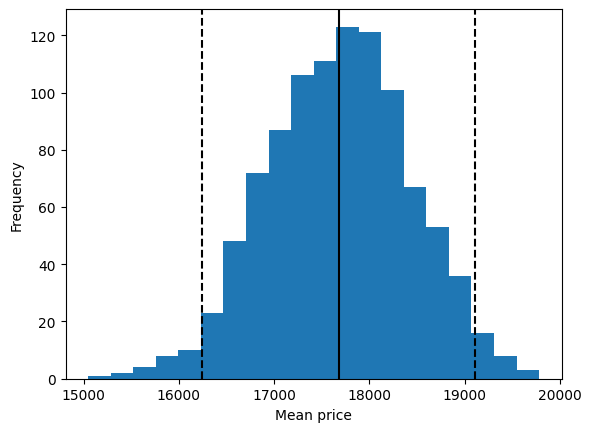

In [10]:
# Visualize the results
fig, ax = plt.subplots()
ax.hist(mean_price, bins=20)
ax.set_xlabel("Mean price")
ax.set_ylabel("Frequency")
ax.axvline(lower, color="black", linestyle="--")
ax.axvline(upper, color="black", linestyle="--")
ax.axvline(np.mean(mean_price), color="black")
plt.show()

In [11]:
from scipy import stats

mean_price = np.mean(df["price"])
std_err_mean = stats.sem(df["price"])
dof = len(df["price"]) - 1
# calculate 95% confidence interval
ci_interval = stats.t.interval(0.95, dof, loc=mean_price, scale=std_err_mean)

print(f'95% confidence interval: [{ci_interval[0]:.2f}, {ci_interval[1]:.2f}]')

95% confidence interval: [16043.56, 19326.44]


# Stratified sampling

In [12]:
rng = np.random.default_rng(seed=123)
df = pd.read_csv("microUCBAdmissions.csv")
resample = (df.groupby("Major")
    .sample(frac=0.1, random_state=rng))
print(f"{len(resample)} rows sampled from {len(df)} rows")
resample.head()

451 rows sampled from 4526 rows


,Admission,Gender,Major
3893,Admitted,Male,A
830,Admitted,Male,A
2916,Rejected,Male,A
925,Admitted,Male,A
844,Admitted,Female,A


In [13]:
pd.DataFrame({
    "Original": df.value_counts("Major") / len(df),
    "Resampled": resample.value_counts("Major") / len(resample)
}).round(3)

,Original,Resampled
Major,,
A,0.206,0.206
C,0.203,0.204
D,0.175,0.175
F,0.158,0.157
B,0.129,0.129
E,0.129,0.129


# Stratified bootstrap sampling for multiple categorical variables

In [14]:
rng = np.random.default_rng(seed=123)
resample = (df.groupby(["Major", "Gender"])
    .sample(frac=1, replace=True, random_state=rng)
    .reset_index(drop=True))
print(f"{len(resample)} rows sampled from {len(df)} rows")
resample.head()

4526 rows sampled from 4526 rows


,Admission,Gender,Major
0,Admitted,Female,A
1,Admitted,Female,A
2,Admitted,Female,A
3,Admitted,Female,A
4,Admitted,Female,A


In [15]:
print(pd.DataFrame({
    "Original": df.value_counts(["Gender", "Major"]),
    "Resampled": resample.value_counts(["Gender", "Major"]),
}).sort_index())

              Original  Resampled
Gender Major                     
Female A           108        108
       B            25         25
       C           593        593
       D           375        375
       E           393        393
       F           341        341
Male   A           825        825
       B           560        560
       C           325        325
       D           417        417
       E           191        191
       F           373        373


In [16]:
rng = np.random.default_rng(seed=123)
df = pd.read_csv("boston-housing.csv")

resample = (df.groupby(pd.cut(df["CRIM"], bins=10),
                       observed=True)
    .sample(frac=0.1, random_state=rng))
print(f"{len(resample)} rows sampled from {len(df)} rows")
resample.head()

26 rows sampled from 267 rows


,CRIM,RM,MEDV
83,1.38799,5.950,13.2
231,3.69311,6.376,17.7
256,0.14866,6.727,27.5
44,2.73397,5.597,15.4
223,0.63796,6.096,18.2


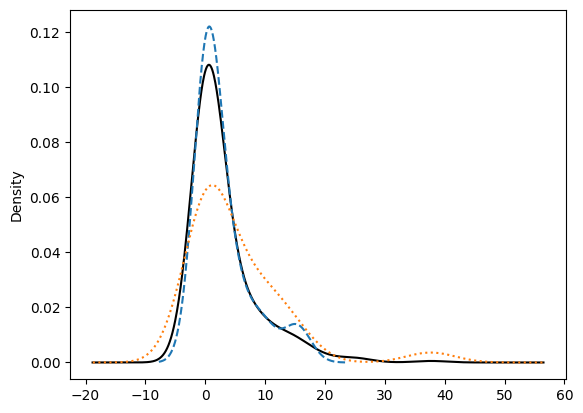

In [17]:
bw_method = 0.5
ax = df["CRIM"].plot.density(color="black", bw_method=bw_method,
                             label="Full dataset")
resample["CRIM"].plot.density(linestyle="--", ax=ax, bw_method=bw_method,
                              label="Stratified sample")
df["CRIM"].sample(frac=0.1, random_state=rng).plot.density(linestyle=":",
                              ax=ax, bw_method=bw_method,
                              label="Random sample")
plt.show()